# 02-750 HW 3 
## Exercise 1
### Anushka Sinha (anushka3)

### Imports

In [10]:
import pandas as pd 
import numpy as np
import math
import copy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import random
from tqdm import tqdm
import GPy
import GPyOpt
import seqlogo

from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

import math

### Data

In [20]:
data = pd.read_csv("ex3_data.csv")
# shuffled_data = data.sample(frac=1).reset_index(drop=True)
shuffled_data = shuffle(data, random_state=42)
shuffled_data_array = shuffled_data.to_numpy()
sequences = shuffled_data_array[:,2]

In [21]:
sequences = shuffled_data_array[:, 2]
affinities = shuffled_data_array[:, -1] # replace 2 with the actual column index for affinity

for i in range(len(sequences)):
    if affinities[i] == 9.0:
        print(sequences[i])

FVPYVLALV
LLLIALWNL
FMFNDLLKL
FTIAMWLLL
YLIGGSATL
FLWLLWPVT
YLLADTFTV
GAWCYDYTV
VLALYSPPL
TLAPFNFLV
HMIDKLFYV
RIFPATHYV
GLLRVISGV
SMFYGIFPS
RQLLWRYQI
ILNDEQLNL
FVFAWFNGV
YLMAWKQVL
FLHTTFIDV
YLPDPTVGV
GLLQFIVFL
AMFIGHATA
WLGHPFTPV
RQIFIHYSV
YLAGWGFVV
FLAVLSPTI
CLDAGINYV
YQLEMYHPI
YLSIYGFGV
FIADIGIGV
FLAGGPHAV
FLLASVYSV
SVFSRPLPL
KLMHLDVTL
LMSFTILCL
AQFLYLYAL
LLLEWLAEV
YVMTMILFL
SLFSLLPGV
GLFGGLNWI
YLLCCNYKL
YLSSVLLAL
ALLSRFFNM
GLAELLAAL
FLADYGWRL
WLYPGAQNL
FIYGYLEPV
VILNYIPVL
TIYSHLLLV
MMISAGFSL
RLHDAWWTL
SLDVINYLI
YLYALIYFL
GIALAVPCV
YTMADLVYA
LLYDGSFAV
YTIERIFNA
FMFNELLAL
LLMMTLPSI
FLDNECHTI
FLSHHFTLV
YLMDKLNLT
FLVPFVVFL
HLVDFQVTI
LLSYYVVYV
ILPVIFLSI
AIIDYIAYM
KVIQYLAYV
TLIDIWFLA
VLMIKALEL
FMFDYIPPV
FLSRLVLYA
FLIPKGFYA
SLFDCIVPV
FLFAFLSAA
FLPDKAIDL
YLSAKVYML
FLNWWIPEV
RLAVYIDKV
ALDEGLLPV
LMDENTYAM
FLSYISDTV
RLLDDLVIV
YLNWFIPPV
GMIPFFDFA
YLDFLLLLL
FQWWRSHPL
TLQDIVLHL
WLMKYPYQL
FLNAFIPPV
FLSRVFFCV
VLAGIFAGV
QMISPVMSV
MLNFSIYSV
LLYDANYFV
YILCNMALL
LLSEIRFYI
FVFAPTHGL
LLIKTLSPA
GLAIFLPLV


### One hot encoding of the sequences

In [12]:
sorted_amino_acids = sorted([
    "A", "R", "N", "D", "C","Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"  
])

aa_mapping = dict()
for i, key in enumerate(sorted_amino_acids):
    aa_mapping[key] = i

def one_hot_encoding(seq_data):
    encoding = []
    for seq in seq_data:
        encoding_map = np.zeros((len(sorted_amino_acids), len(seq)))
        for i, aa in enumerate(seq):
            aa_index = aa_mapping[aa]
            encoding_map[aa_index, i] = 1
        encoding.append(encoding_map.flatten())
    return encoding

encoded_sequences = one_hot_encoding(sequences)


### 3a. Implement a Bayesian optimizer with Gaussian Process as regressor and use any selection/acquisition function that combines exploitation and exploration.

In [13]:
def GP_analysis(X, Y, X_grid):
    k = GPy.kern.RBF(X.shape[1])
    
    # Use GP regression to fit the data
    m = GPy.models.SparseGPRegression(X, Y, k)
    m.optimize('bfgs', max_iters=10)

    # Predict the mean and covariance of the GP fit over the grid
    mean, variance = m.predict(X_grid, full_cov=False)
    return mean, variance, m

In [14]:
def gaussian_process(X, data_array):
    X = np.array(X)
    BO_lambda = .15
    BO_number_of_iterations = 1
    # Get the encoded sequences
    y = data_array[:, -1].reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
   
    Dsize = len(X)
    high_binding_affinity_seqs = []
    percentages = []

    # Run the loop for 200 steps
    for i in range(1, 201):

        # Use GP regression to fit the data
        mean, variance, m = GP_analysis(X_train, y_train, X_test)

        # Compute UCB (selection function)
        BO_beta = 2 * math.log(Dsize * math.pow(BO_number_of_iterations,2) * math.pow(np.pi,2) / (6 * BO_lambda) )
        alpha_full = mean + math.sqrt(BO_beta) * variance

        # Find the next sample
        next_sample_index = np.argmax(alpha_full)

        # Collect the indices of the selected queries whose true label is an affinity of 9.0
        if y_test[next_sample_index,0] == 9.0:
            high_binding_affinity_seqs.append(next_sample_index)
        
        # Calculate cumulative percentage of instances that result in max binding affinity  
        high_affinity_percentage = (len(high_binding_affinity_seqs)/i)*100
        percentages.append(high_affinity_percentage)

        # Add the desired sample to our data
        X_train = np.vstack((X_train, X_test[next_sample_index,:]))
        y_train = np.vstack((y_train, y_test[next_sample_index]))

        # Remove the desired sample from test set 
        X_test = np.delete(X_test, next_sample_index, axis=0)
        y_test = np.delete(y_test, next_sample_index, axis=0)
        data_array = np.delete(data_array, next_sample_index)

    return high_binding_affinity_seqs, percentages

seqs, per = gaussian_process(encoded_sequences, shuffled_data_array)
print(len(seqs))

29


In [15]:
GP_sequences = shuffled_data_array[seqs, 2:-1] 
GP_sequences = GP_sequences.flatten().tolist()
for seq in GP_sequences:
    print(seq)

WLSVIAFGK
TLLNETAKV
YIWIKNLET
LLLRPFWPA
TLIDIWFLA
FLFQLNDTI
GMGPSLIGL
YLDMVLAFL
AAHARFVAA
FLVIAINAM
VPADHRLAF
WLGDVWQEK
RQKLKDAEK
LAIVTTPLV
YICSQQDTL
EVADRVIFM
RSEVELCIY
NTYLFNILY
DLKDQIAQL
LLTDTIESA
AINVEKIEL
MVDEEPAAL
FTFEWNGRI
ITTFIPISA
SLYNTIATL
LLLEAGALV
FVFDRPLPV
FVTWHRYHL
IFINKLNGA


### 3b. Implement a random query strategy for randomly selecting a sample to query from the data

In [16]:
def random_sampling(X, data_array):
    X = np.array(X)
    y = data_array[:, -1].reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    high_binding_affinity_seqs = []
    percentages = []
    
    # Run for 200 steps 
    for i in range(1, 201):
        
        # Randomly select the next sample
        next_sample_index = np.random.randint(0, len(y_test))
        
        # Collect the indices of the selected queries whose true label is an affinity of 9.0
        if y_test[next_sample_index,0] == 9.0:
            high_binding_affinity_seqs.append(next_sample_index)

        # Calculate cumulative percentage of instances that result in max binding affinity 
        high_affinity_percentage = (len(high_binding_affinity_seqs) / i) * 100
        percentages.append(high_affinity_percentage)

        # Add the selected sample to our data
        X_train = np.vstack((X_train, X_test[next_sample_index,:]))
        y_train = np.vstack((y_train, y_test[next_sample_index,0]))

        # Remove the selected sample from test set and data array
        X_test = np.delete(X_test, next_sample_index, axis=0)
        y_test = np.delete(y_test, next_sample_index, axis=0)
        data_array = np.delete(data_array, next_sample_index, axis=0)

    return high_binding_affinity_seqs, percentages


random_seqs, random_percentages = random_sampling(encoded_sequences, shuffled_data_array)


In [17]:
random_sequences = shuffled_data_array[random_seqs, 2:-1] 
random_sequences = random_sequences.flatten().tolist()
for seq in random_sequences:
    print(seq)

AAMYQYIFL
FLVPFVVFL
VPAWLPLGI
SSMNSDAAY
AEHFENQVL
AAQLQAVPG
ALDLSHFLK


### 3c. Plot the cumulative percentage of sequences with maximum binding affinity with respect to number of sequences queried for 3a and 3b

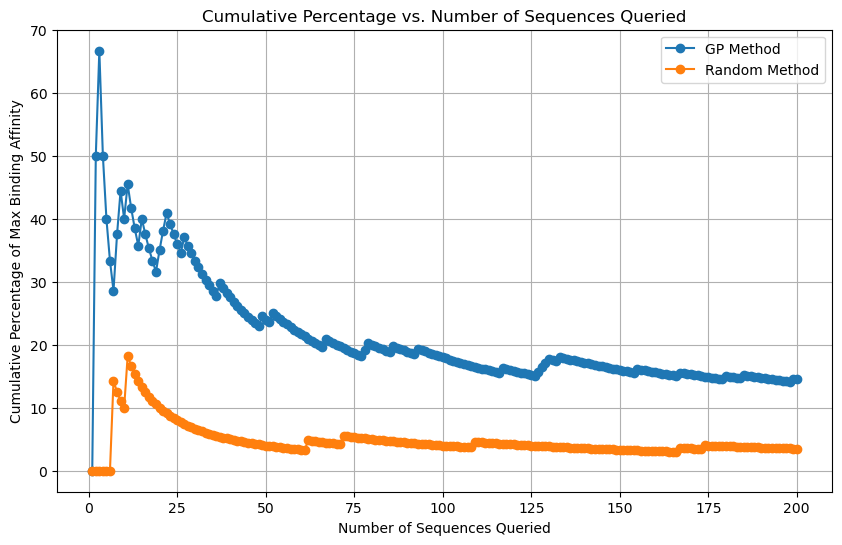

In [18]:
# Number of sequences queried (x-axis values)
num_sequences_queried_GP = list(range(1, len(per) + 1))
num_sequences_queried_random = list(range(1, len(random_percentages) + 1))

# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(num_sequences_queried_GP, per, marker='o', linestyle='-', label='GP Method')
plt.plot(num_sequences_queried_random, random_percentages, marker='o', linestyle='-', label='Random Method')

plt.xlabel('Number of Sequences Queried')
plt.ylabel('Cumulative Percentage of Max Binding Affinity')
plt.title('Cumulative Percentage vs. Number of Sequences Queried')
plt.legend()  # This adds the legend to the plot
plt.grid(True)
plt.show()